In [1]:
import math as maths

import cartopy.crs as ccrs
import cartopy.feature as cf
import intake
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import easygems.healpix as egh
import os

savedir = '/home/users/train045/Documents/WCRP25_hackathon/figs/'
# os.makedirs(savedir, exist_ok=True)

/home/users/train045/miniforge3/envs/wcrp_hackathon/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
import warnings

# Suppress specific FutureWarnings matching the message pattern when using cat[...].to_dask()
warnings.filterwarnings(
    "ignore",
    message=".*The return type of `Dataset.dims` will be changed.*",
    category=FutureWarning,
)

In [3]:
cat = intake.open_catalog('https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml')['online']

In [4]:
# icon_ngc4008: 

# daily time and cell mean vertical velocity 

# ds = cat['icon_ngc4008'](zoom=9, time='P1D').to_dask()
# ds.wa_phy

In [5]:
cat['icon_d3hp003aug'].describe()["user_parameters"]

[{'name': 'time',
  'description': 'time resolution of the dataset',
  'type': 'str',
  'allowed': ['PT15M', 'PT3H', 'PT6H'],
  'default': 'PT15M'},
 {'name': 'time_method',
  'description': 'time subsetting method',
  'type': 'str',
  'allowed': ['mean', 'inst'],
  'default': 'inst'},
 {'name': 'zoom',
  'description': 'zoom resolution of the dataset',
  'type': 'int',
  'allowed': [11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0],
  'default': 0}]

In [6]:
# icon_d3hp003aug:

# intantaneous, zoom 11 ! One day.

ds = cat['icon_d3hp003aug'](zoom=11, time='PT15M').to_dask().pipe(egh.attach_coords)
ds.wa

<xarray.DataArray 'wa' (time: 96, pressure: 30, cell: 50331648)> Size: 580GB
[144955146240 values with dtype=float32]
Coordinates:
  * pressure  (pressure) int64 240B 5 10 20 50 100 ... 92500 95000 97500 100000
  * time      (time) datetime64[ns] 768B 2020-08-01T00:15:00 ... 2020-08-02
    crs       int64 8B 0
  * cell      (cell) int64 403MB 0 1 2 3 ... 50331644 50331645 50331646 50331647
    lat       (cell) float64 403MB 0.01865 0.0373 0.0373 ... -0.0373 -0.01865
    lon       (cell) float64 403MB 45.0 45.02 44.98 45.0 ... 315.0 315.0 315.0
Attributes:
    grid_mapping:        crs
    hiopy::time_method:  point
    hiopy::src_name:     pl::wa_phy
    hiopy::nnn:          4
    hiopy::enable:       True
    standard_name:       upward_air_velocity
    units:               m s-1
    short_name:          
    long_name:           vertical velocity in m/s

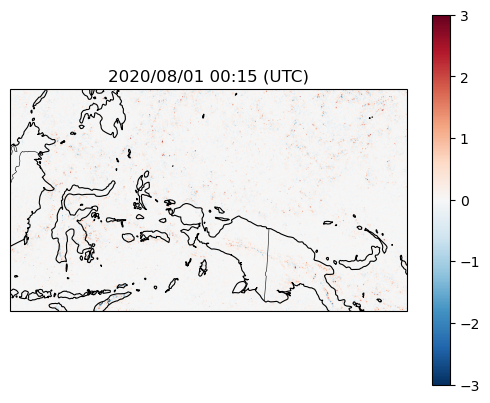

In [7]:
# view one instant of max updrafts

# Oxford coods (51 N, 15 W)

projection = ccrs.Robinson(central_longitude=0)
fig, ax = plt.subplots(subplot_kw={'projection': projection}, )
# ax.set_extent([10,20,45,55], crs=ccrs.PlateCarree()) # Oxford
ax.set_extent([115,155,-10,10], crs=ccrs.PlateCarree()) # Warm Pool

# ax.set_extent([0,80,-30,30], crs=ccrs.PlateCarree())

d = ds.wa.sel(pressure = slice(20000, 100000)).isel(time=0).isel(pressure=10)#.max('pressure')
p = egh.healpix_show(d, ax=ax, cmap='RdBu_r', vmin=-3, vmax=3)

fig.colorbar(p)
ax.set_title(d.time.dt.strftime('%Y/%m/%d %H:%M (UTC)').item())

ax.add_feature(cf.COASTLINE, linewidth=0.8)
ax.add_feature(cf.BORDERS, linewidth=0.4)

tstr = d.time.dt.strftime('%Y%m%dT%H%M').item()
fig.savefig(savedir + f'map_updrafts_WPWP-{tstr}.jpg', dpi=100)

In [8]:
domain_extents = {
    "global": (0, 360, -90, 90),
    "amazon": (280, 325, -15, 10),
    "congo": (0, 35, -12, 24),
    "warm pool": (90, 160, -15, 15),
    "tropics": (0, 360, -30.1, 30.1),
}

def extent_mask(ds, extent):
    lon_min, lon_max, lat_min, lat_max = extent
    return (ds["lon"] > lon_min) & (ds["lon"] < lon_max) & (ds["lat"] > lat_min) & (ds["lat"] < lat_max)

def cells_of_domain(ds, domain_name):
    return np.where(extent_mask(ds, domain_extents[domain_name]))[0]

In [9]:
# tropics only

t_cells = cells_of_domain(ds, domain_name='tropics')
t = ds.sel(cell=t_cells)


In [10]:
ex = t.isel(time=0)

In [11]:
# distribution

ex_max = ex.wa.sel(pressure = slice(10000, 100000)).max('pressure')

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4))


for ax in axs:
    ex_max.plot.hist(ax=ax, color='grey')
    ax.set_title(ex_max.time.dt.strftime('%Y-%m-%d %H:%M (UTC)').item())
    ax.set_ylabel('frequency')
    ax.set_xlabel('vertical velocity (m/s)')


axs[1].set_yscale('log')
axs[1].set_ylabel('log frequency')

tstr = ex_max.time.dt.strftime('%Y%m%dT%H%M').item()
# fig.savefig(savedir + f'updrafts_dist_tropics-{tstr}.jpg')
fig.savefig(savedir + f'updrafts_dist_tropics-zoom11-{tstr}.jpg') # log scale

In [16]:
# now compare 10 km

In [17]:
ds10 = cat['icon_d3hp003aug'](zoom=9, time='PT15M').to_dask().pipe(egh.attach_coords)

In [19]:
ex10 = ds10.sel(cell=cells_of_domain(ds10, domain_name='tropics')).isel(time=0)
ex_max10 = ex10.wa.sel(pressure = slice(10000, 100000)).max('pressure')

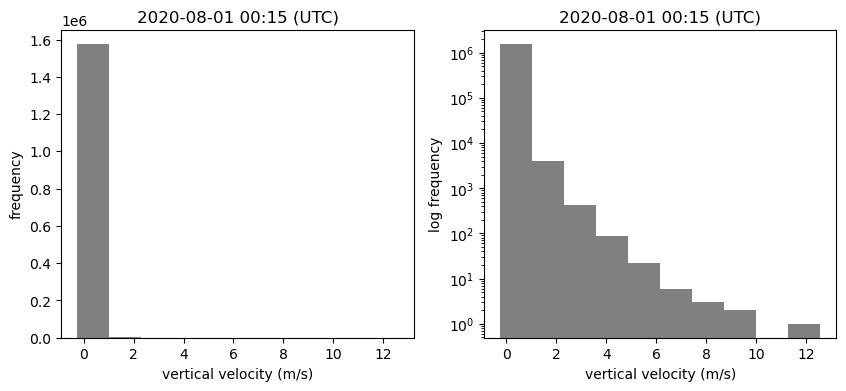

In [21]:
fig, axs = plt.subplots(1,2, figsize=(10,4))


for ax in axs:
    ex_max10.plot.hist(ax=ax, color='grey')
    ax.set_title(ex_max10.time.dt.strftime('%Y-%m-%d %H:%M (UTC)').item())
    ax.set_ylabel('frequency')
    ax.set_xlabel('vertical velocity (m/s)')


axs[1].set_yscale('log')
axs[1].set_ylabel('log frequency')

tstr = ex_max10.time.dt.strftime('%Y%m%dT%H%M').item()
# fig.savefig(savedir + f'updrafts_dist_tropics-{tstr}.jpg')
fig.savefig(savedir + f'updrafts_dist_tropics-zoom9-{tstr}.jpg') # log scale